# Y branch 

splitter and combiner

In [1]:
# importing necessary packages
import gplugins.modes as gmode
import numpy as np
import matplotlib.pyplot as plt
import meep as mp
import gdsfactory as gf
import gplugins.gmeep as gm

Using MPI version 4.1, 1 processes
2025-10-27 18:39:13.857 | INFO     | gplugins.gmeep:<module>:39 - Meep '1.31.0' installed at ['/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep']


## Y-branch from gdsfactory

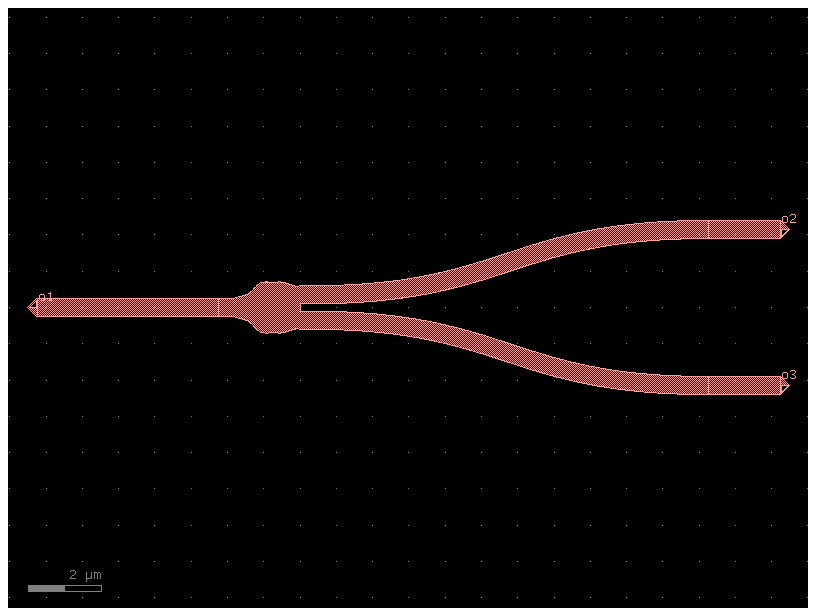

In [2]:
gf.clear_cache()
ybranch = gf.Component("ybranch")

inwg = gf.components.straight(length=5)
outwg = gf.components.straight(length=2)
splitter = gf.components.mmi1x2_with_sbend()

inwg_ref = ybranch.add_ref(inwg)
splitter_ref = ybranch.add_ref(splitter)
outwg_top_ref = ybranch.add_ref(outwg)
outwg_bot_ref = ybranch.add_ref(outwg)

# Connecting ports
inwg_ref.connect("o2", splitter_ref.ports["o1"])
outwg_top_ref.connect("o1", splitter_ref.ports["o2"])
outwg_bot_ref.connect("o1", splitter_ref.ports["o3"])

# adding port name
ybranch.add_port(name=f"o1", port=inwg_ref.ports["o1"])
ybranch.add_port(name=f"o2", port=outwg_top_ref.ports["o2"])
ybranch.add_port(name=f"o3", port=outwg_bot_ref.ports["o2"])
ybranch.auto_rename_ports()

# plotting
ybranch.draw_ports()
ybranch.plot()

## Meep simulation 

S-parameter calculation and steady-state fields

### 50-50 splitter 

Input port 1, will not be exact 50-50 because of the losses at the split

     prism, center = (0.680495,-3.50597e-17,0.11)
          height 0.22, axis (0,0,1), sidewall angle: 0 radians, 570 vertices:
          (8.25,-2.4,0)
          (8.082,-2.399,0)
          (7.917,-2.398,0)
          (7.755,-2.395,0)
          (7.596,-2.391,0)
          (7.441,-2.386,0)
          (7.289,-2.38,0)
          (7.139,-2.373,0)
          (6.993,-2.366,0)
          (6.849,-2.357,0)
          (6.708,-2.347,0)
          (6.57,-2.336,0)
          (6.434,-2.325,0)
          (6.302,-2.312,0)
          (6.171,-2.299,0)
          (6.043,-2.285,0)
          (5.918,-2.27,0)
          (5.794,-2.254,0)
          (5.673,-2.238,0)
          (5.554,-2.221,0)
          (5.437,-2.203,0)
          (5.323,-2.184,0)
          (5.21,-2.165,0)
          (5.099,-2.145,0)
          (4.99,-2.125,0)
          (4.883,-2.103,0)
          (4.777,-2.082,0)
          (4.673,-2.06,0)
          (4.571,-2.037,0)
          (4.47,-2.014,0)
          (4.371,-1.99,0)
          (4.273,-1.966,0)
          (4.176,-1

          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
subpixel-averaging is 14.1413% done, 27.2307 s remaining
subpixel-averaging is 26.5164% done, 11.1034 s remaining
subpixel-averaging is 33.5879% done, 8.38802 s remaining
subpixel-averaging is 40.6594% done, 6.33823 s remaining
subpixel-averaging is 45.9631% done, 4.76998 s remaining
subpixel-averaging is 51.2667% done, 3.89732 s remaining
subpixel-averaging is 58.3382% done, 3.78463 s remaining
subpixel-averaging is 63.6418% done, 2.28628 s remaining
subpixel-averaging is 70.7133% done, 2.20086 s remaining
subpixel-averaging is 77.7848% done, 1.50156 s remaining
subpixel-averaging is 84.8564% done, 0.943251 s remaining
subpixel-averaging is 93.6957% done, 0.308967 s remaining
subpixel-averaging is 14.1413% done, 26.1722 s remaining
subpixel-averaging is 28.2843% done, 12.9301 s remaining
subpixel-averaging is 35.3558% done, 7.61426 s remaining
subpixel-averaging is 42.4273% done, 6.44351 s remaining
subpixel-av

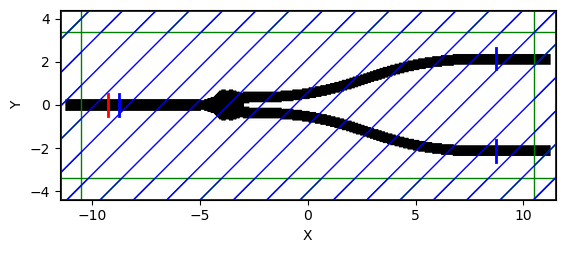

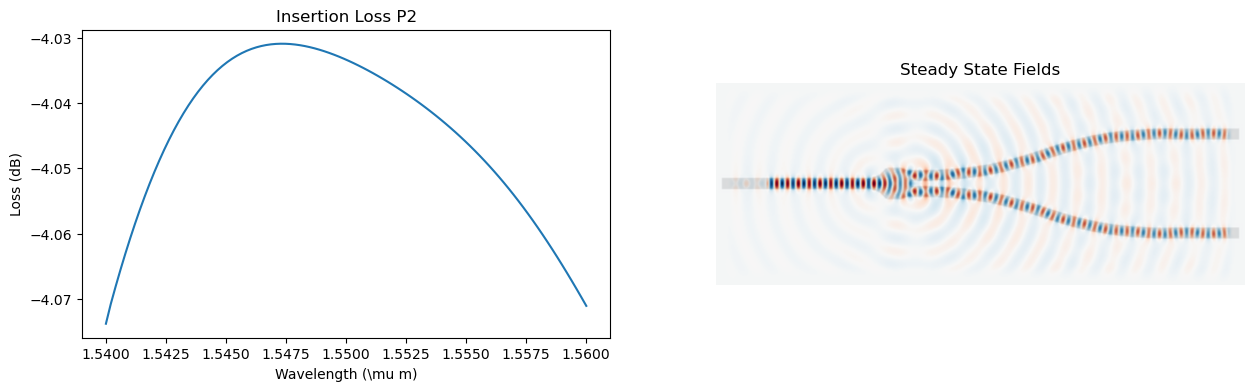

In [3]:
from gdsfactory.technology import LayerLevel, LayerStack

mp.verbosity(1)

# Set up frequency points for simulation
npoints = 100
lcen = 1.55
dlam = 0.02
wl = np.linspace(lcen - dlam / 2, lcen + dlam / 2, npoints)
fcen = 1 / lcen
fwidth = 3 * dlam / lcen**2
fpoints = 1 / wl  # Center frequency
mode_parity = mp.EVEN_Y + mp.ODD_Z
dpml = 1
dpad = 1
resolution = 20

# Define materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

cell_size = mp.Vector3(ybranch.xsize + 2 * dpml, ybranch.ysize + 2 * dpml + 2 * dpad, 0)

ybranch = gf.components.extend_ports(ybranch, port_names=["o1", "o2", "o3"], length=1)
ybranch = ybranch.copy()
ybranch.flatten()
ybranch.center = (0, 0)

geometry = gm.get_meep_geometry.get_meep_geometry_from_component(ybranch)

geometry = [
    mp.Prism(geom.vertices, geom.height, geom.axis, geom.center, material=Si)
    for geom in geometry
]

src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src=src,
        eig_band=1,
        eig_parity=mode_parity,
        size=mp.Vector3(0, 1),
        center=mp.Vector3(ybranch.ports["o1"].x + dpml + 1, ybranch["o1"].y),
    )
]
sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=[
        mp.PML(dpml)
    ],  # the boundary layers to absorb fields that leave the simulation
    sources=source,  # The sources
    geometry=geometry,  # The geometry
    default_material=SiO2,
)
m1 = mp.Volume(
    center=mp.Vector3(ybranch.ports["o1"].x + dpml + 1 + 0.5, ybranch["o1"].y),
    size=mp.Vector3(0, 1),
)
m2 = mp.Volume(
    center=mp.Vector3(ybranch.ports["o2"].x - dpml - 1 - 0.5, ybranch["o2"].y),
    size=mp.Vector3(0, 1),
)
m3 = mp.Volume(
    center=mp.Vector3(ybranch.ports["o3"].x - dpml - 1 - 0.5, ybranch["o3"].y),
    size=mp.Vector3(0, 1),
)

mode_monitor_1 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m1))
mode_monitor_2 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m2))
mode_monitor_3 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m3))
whole_dft = sim.add_dft_fields([mp.Ez], fcen, 0, 1, center=mp.Vector3(), size=cell_size)

sim.plot2D(labels=False)

sim.run(until_after_sources=mp.stop_when_dft_decayed(tol=1e-4))

# Finds the S parameters
norm_mode_coeff = sim.get_eigenmode_coefficients(
    mode_monitor_1, [1], eig_parity=mode_parity
).alpha[0, :, 0]
port1_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_1, [1], eig_parity=mode_parity).alpha[
        0, :, 1
    ]
    / norm_mode_coeff
)

port2_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_2, [1], eig_parity=mode_parity).alpha[
        0, :, 0
    ]
    / norm_mode_coeff
)
port3_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_3, [1], eig_parity=mode_parity).alpha[
        0, :, 0
    ]
    / norm_mode_coeff
)

# Calculates the transmittance based off of the S parameters
port1_trans = abs(port1_coeff) ** 2
port2_trans = abs(port2_coeff) ** 2
port3_trans = abs(port3_coeff) ** 2
insertion_loss_dB = 10*np.log10(port2_trans)
fig = plt.figure(figsize=(15, 4))

ax_loss = fig.add_subplot(1,2,1)
ax_loss.set_title("Insertion Loss P2")
ax_loss.plot(wl,insertion_loss_dB)
ax_loss.set_xlabel(r"Wavelength (\mu m)")
ax_loss.set_ylabel("Loss (dB)")

# ax_trans1 = fig.add_subplot(1, 3, 1)
# ax_trans1.set_title("Transmission per Port")
# ax_trans1.plot(wl, port1_trans, label=r"s11^2")
# ax_trans1.plot(wl, port2_trans, label=r"s21^2")
# ax_trans1.plot(wl, port3_trans, label=r"s31^2")
# ax_trans1.set_xlabel(r"Wavelength (\mu m)")
# ax_trans1.set_ylabel(r"Transmission")
# ax_trans1.legend()

# ax_phase1 = fig.add_subplot(1, 3, 2)
# ax_phase1.set_title("Phase per Port")
# ax_phase1.plot(
#     wl, np.unwrap(np.angle(port1_coeff) * 180 / np.pi), label=r"phase of s11"
# )
# ax_phase1.plot(
#     wl, np.unwrap(np.angle(port2_coeff) * 180 / np.pi), label=r"phase of s21"
# )
# ax_phase1.plot(
#     wl, np.unwrap(np.angle(port3_coeff) * 180 / np.pi), label=r"phase of s31"
# )
# ax_phase1.set_xlabel(r"Wavelength (\mu m)")
# ax_phase1.set_ylabel("Angle (deg)")
# ax_phase1.legend()

# sim.reset_meep()

# sim.run(until_after_sources=mp.stop_when_dft_decayed(tol=1e-4))

eps_data = sim.get_epsilon()  #
ez_data = sim.get_dft_array(
    whole_dft, mp.Ez, 0
)  # Values for the component of the E-field in the z direction (in/out of screen)

# Creates the plot
ax_field = fig.add_subplot(1, 2, 2)
ax_field.set_title("Steady State Fields")
ax_field.imshow(np.transpose(eps_data), interpolation="spline36", cmap="binary")
ax_field.imshow(
    np.flipud(np.transpose(np.real(ez_data))),
    interpolation="spline36",
    cmap="RdBu",
    alpha=0.9,
)
ax_field.axis("off")
plt.show()

### Input in single guide

Splitter

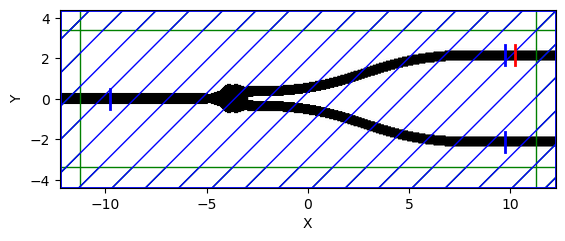

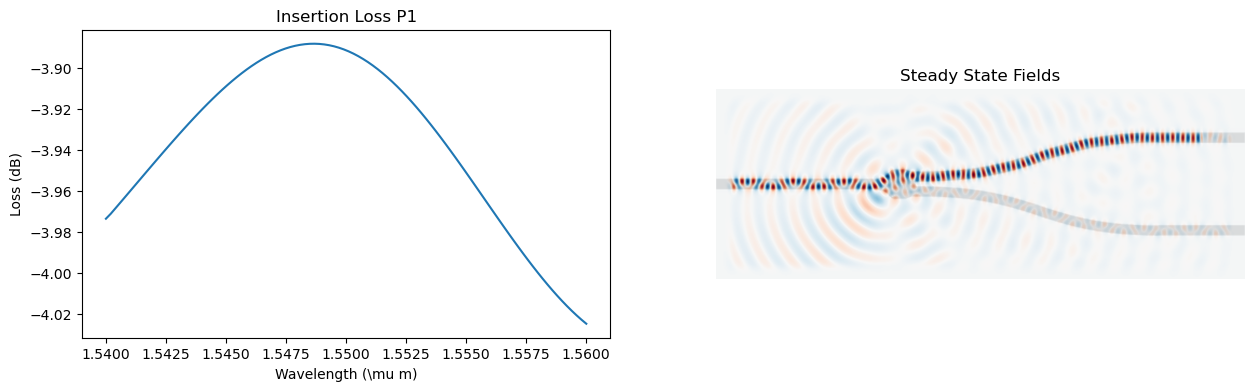

In [6]:
from gdsfactory.technology import LayerLevel, LayerStack

mp.verbosity(0)

# Set up frequency points for simulation
npoints = 100
lcen = 1.55
dlam = 0.02
wl = np.linspace(lcen - dlam / 2, lcen + dlam / 2, npoints)
fcen = 1 / lcen
fwidth = 3 * dlam / lcen**2
fpoints = 1 / wl  # Center frequency
mode_parity = mp.EVEN_Y + mp.ODD_Z
dpml = 1
dpad = 1
resolution = 20

# Define materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

cell_size = mp.Vector3(ybranch.xsize + 2 * dpml, ybranch.ysize + 2 * dpml + 2 * dpad, 0)

ybranch = gf.components.extend_ports(ybranch, port_names=["o1", "o2", "o3"], length=1)
ybranch = ybranch.copy()
ybranch.flatten()
ybranch.center = (0, 0)

geometry = gm.get_meep_geometry.get_meep_geometry_from_component(ybranch)

geometry = [
    mp.Prism(geom.vertices, geom.height, geom.axis, geom.center, material=Si)
    for geom in geometry
]

src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src=src,
        eig_band=1,
        eig_parity=mode_parity,
        eig_kpoint = mp.Vector3(-1,0,0),
        direction = mp.NO_DIRECTION,
        size=mp.Vector3(0, 1),
        center=mp.Vector3(ybranch.ports["o2"].x - dpml - 1, ybranch["o2"].y),
        amplitude=1
    ),
    # mp.EigenModeSource(
    #     src=src,
    #     eig_band=1,
    #     eig_parity=mode_parity,
    #     eig_kpoint = mp.Vector3(-1,0,0),
    #     direction = mp.NO_DIRECTION,
    #     size=mp.Vector3(0, 1),
    #     center=mp.Vector3(ybranch.ports["o3"].x - dpml - 1, ybranch["o3"].y),
    #     amplitude=1
    # ),
]
sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=[mp.PML(dpml)],  # 
    sources=source,  # The sources
    geometry=geometry,  # The geometry
    default_material=SiO2,
)
m1 = mp.Volume(
    center=mp.Vector3(ybranch.ports["o1"].x + dpml + 1 + 0.5, ybranch["o1"].y),
    size=mp.Vector3(0, 1),
)
m2 = mp.Volume(
    center=mp.Vector3(ybranch.ports["o2"].x - dpml - 1 - 0.5, ybranch["o2"].y),
    size=mp.Vector3(0, 1),
)
m3 = mp.Volume(
    center=mp.Vector3(ybranch.ports["o3"].x - dpml - 1 - 0.5, ybranch["o3"].y),
    size=mp.Vector3(0, 1),
)

mode_monitor_1 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m1))
mode_monitor_2 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m2))
mode_monitor_3 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m3))
whole_dft = sim.add_dft_fields([mp.Ez], fcen, 0, 1, center=mp.Vector3(), size=cell_size)

sim.plot2D(labels=False)

sim.run(until_after_sources=mp.stop_when_dft_decayed(tol=1e-4))

# Finds the S parameters
norm_mode_coeff = sim.get_eigenmode_coefficients(
    mode_monitor_2, [1], eig_parity=mode_parity
).alpha[0, :, 1]  # Adding both the ports input values

port1_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_1, [1], eig_parity=mode_parity).alpha[
        0, :, 1
    ]
    / norm_mode_coeff
)

port2_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_2, [1], eig_parity=mode_parity).alpha[
        0, :, 0
    ]
    / norm_mode_coeff
)
port3_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_3, [1], eig_parity=mode_parity).alpha[
        0, :, 0
    ]
    / norm_mode_coeff
)

# Calculates the transmittance based off of the S parameters
port1_trans = abs(port1_coeff) ** 2
port2_trans = abs(port2_coeff) ** 2
port3_trans = abs(port3_coeff) ** 2
insertion_loss_dB = 10*np.log10(port1_trans)

fig = plt.figure(figsize=(15, 4))

ax_loss = fig.add_subplot(1,2,1)
ax_loss.set_title("Insertion Loss P1")
ax_loss.plot(wl,insertion_loss_dB)
ax_loss.set_xlabel(r"Wavelength (\mu m)")
ax_loss.set_ylabel("Loss (dB)")

# ax_trans1 = fig.add_subplot(1, 3, 1)
# ax_trans1.set_title("Transmission per Port")
# ax_trans1.plot(wl, port1_trans, label=r"s1(23)^2") # Not the proper way to represent 
# ax_trans1.plot(wl, port2_trans, label=r"s22^2")
# ax_trans1.plot(wl, port3_trans, label=r"s33^2")
# ax_trans1.set_xlabel(r"Wavelength (\mu m)")
# ax_trans1.set_ylabel(r"Transmission")
# ax_trans1.legend()

# ax_phase1 = fig.add_subplot(1, 3, 2)
# ax_phase1.set_title("Phase per Port")
# ax_phase1.plot(
#     wl, np.unwrap(np.angle(port1_coeff) * 180 / np.pi), label=r"phase of s1(23)"
# )
# ax_phase1.plot(
#     wl, np.unwrap(np.angle(port2_coeff) * 180 / np.pi), label=r"phase of s22"
# )
# ax_phase1.plot(
#     wl, np.unwrap(np.angle(port3_coeff) * 180 / np.pi), label=r"phase of s33"
# )
# ax_phase1.set_xlabel(r"Wavelength (\mu m)")
# ax_phase1.set_ylabel("Angle (deg)")
# ax_phase1.legend()

# sim.reset_meep()

# sim.run(until_after_sources=mp.stop_when_dft_decayed(tol=1e-4))

eps_data = sim.get_epsilon()  #
ez_data = sim.get_dft_array(
    whole_dft, mp.Ez, 0
)  # Values for the component of the E-field in the z direction (in/out of screen)

# Creates the plot
ax_field = fig.add_subplot(1, 2, 2)
ax_field.set_title("Steady State Fields")
ax_field.imshow(np.transpose(eps_data), interpolation="spline36", cmap="binary")
ax_field.imshow(
    np.flipud(np.transpose(np.real(ez_data))),
    interpolation="spline36",
    cmap="RdBu",
    alpha=0.9,
)
ax_field.axis("off")
plt.show()

### Combiner

#### Out-phase

distructive interference

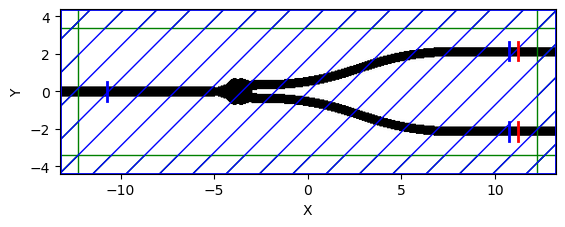

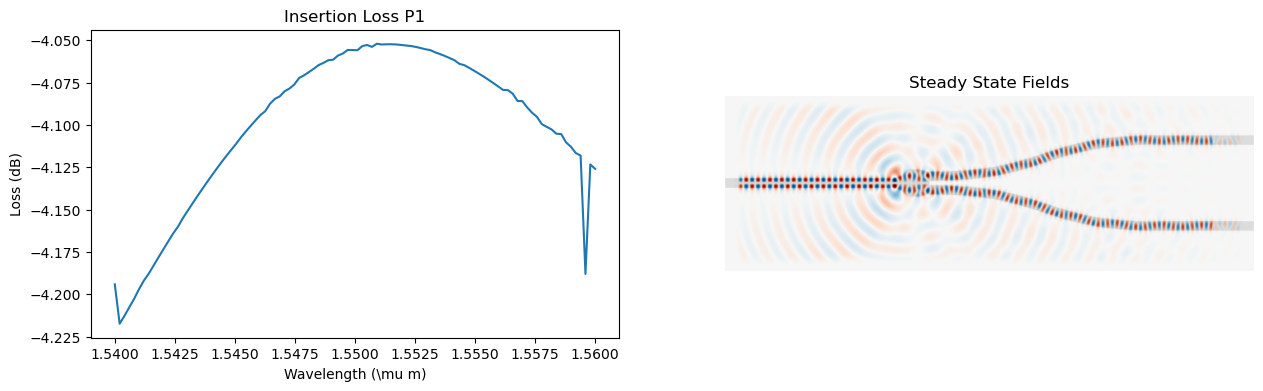

In [7]:
from gdsfactory.technology import LayerLevel, LayerStack

mp.verbosity(0)

# Set up frequency points for simulation
npoints = 100
lcen = 1.55
dlam = 0.02
wl = np.linspace(lcen - dlam / 2, lcen + dlam / 2, npoints)
fcen = 1 / lcen
fwidth = 3 * dlam / lcen**2
fpoints = 1 / wl  # Center frequency
mode_parity = mp.EVEN_Y + mp.ODD_Z
dpml = 1
dpad = 1
resolution = 20

# Define materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

cell_size = mp.Vector3(ybranch.xsize + 2 * dpml, ybranch.ysize + 2 * dpml + 2 * dpad, 0)

ybranch = gf.components.extend_ports(ybranch, port_names=["o1", "o2", "o3"], length=1)
ybranch = ybranch.copy()
ybranch.flatten()
ybranch.center = (0, 0)

geometry = gm.get_meep_geometry.get_meep_geometry_from_component(ybranch)

geometry = [
    mp.Prism(geom.vertices, geom.height, geom.axis, geom.center, material=Si)
    for geom in geometry
]

src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src=src,
        eig_band=1,
        eig_parity=mode_parity,
        eig_kpoint = mp.Vector3(-1,0,0),
        direction = mp.NO_DIRECTION,
        size=mp.Vector3(0, 1),
        center=mp.Vector3(ybranch.ports["o2"].x - dpml - 1, ybranch["o2"].y),
        amplitude=1
    ),
    mp.EigenModeSource(
        src=src,
        eig_band=1,
        eig_parity=mode_parity,
        eig_kpoint = mp.Vector3(-1,0,0),
        direction = mp.NO_DIRECTION,
        size=mp.Vector3(0, 1),
        center=mp.Vector3(ybranch.ports["o3"].x - dpml - 1, ybranch["o3"].y),
        amplitude=-1
    ),
]
sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=[mp.PML(dpml)],  # 
    sources=source,  # The sources
    geometry=geometry,  # The geometry
    default_material=SiO2,
)
m1 = mp.Volume(
    center=mp.Vector3(ybranch.ports["o1"].x + dpml + 1 + 0.5, ybranch["o1"].y),
    size=mp.Vector3(0, 1),
)
m2 = mp.Volume(
    center=mp.Vector3(ybranch.ports["o2"].x - dpml - 1 - 0.5, ybranch["o2"].y),
    size=mp.Vector3(0, 1),
)
m3 = mp.Volume(
    center=mp.Vector3(ybranch.ports["o3"].x - dpml - 1 - 0.5, ybranch["o3"].y),
    size=mp.Vector3(0, 1),
)

mode_monitor_1 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m1))
mode_monitor_2 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m2))
mode_monitor_3 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m3))
whole_dft = sim.add_dft_fields([mp.Ez], fcen, 0, 1, center=mp.Vector3(), size=cell_size)

sim.plot2D(labels=False)

sim.run(until_after_sources=mp.stop_when_dft_decayed(tol=1e-4))

# Finds the S parameters
norm_mode_coeff = sim.get_eigenmode_coefficients(
    mode_monitor_2, [1], eig_parity=mode_parity
).alpha[0, :, 1] + sim.get_eigenmode_coefficients(
    mode_monitor_3, [1], eig_parity=mode_parity
).alpha[0, :, 1] # Adding both the ports input values

port1_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_1, [1], eig_parity=mode_parity).alpha[
        0, :, 1
    ]
    / norm_mode_coeff
)

port2_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_2, [1], eig_parity=mode_parity).alpha[
        0, :, 0
    ]
    / norm_mode_coeff
)
port3_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_3, [1], eig_parity=mode_parity).alpha[
        0, :, 0
    ]
    / norm_mode_coeff
)

# Calculates the transmittance based off of the S parameters
port1_trans = abs(port1_coeff) ** 2
port2_trans = abs(port2_coeff) ** 2
port3_trans = abs(port3_coeff) ** 2
insertion_loss_dB = 10*np.log10(port1_trans)
fig = plt.figure(figsize=(15, 4))

ax_loss = fig.add_subplot(1,2,1)
ax_loss.set_title("Insertion Loss P1")
ax_loss.plot(wl,insertion_loss_dB)
ax_loss.set_xlabel(r"Wavelength (\mu m)")
ax_loss.set_ylabel("Loss (dB)")

# ax_trans1 = fig.add_subplot(1, 3, 1)
# ax_trans1.set_title("Transmission per Port")
# ax_trans1.plot(wl, port1_trans, label=r"s1(23)^2") # Not the proper way to represent 
# ax_trans1.plot(wl, port2_trans, label=r"s22^2")
# ax_trans1.plot(wl, port3_trans, label=r"s33^2")
# ax_trans1.set_xlabel(r"Wavelength (\mu m)")
# ax_trans1.set_ylabel(r"Transmission")
# ax_trans1.legend()

# ax_phase1 = fig.add_subplot(1, 3, 2)
# ax_phase1.set_title("Phase per Port")
# ax_phase1.plot(
#     wl, np.unwrap(np.angle(port1_coeff) * 180 / np.pi), label=r"phase of s1(23)"
# )
# ax_phase1.plot(
#     wl, np.unwrap(np.angle(port2_coeff) * 180 / np.pi), label=r"phase of s22"
# )
# ax_phase1.plot(
#     wl, np.unwrap(np.angle(port3_coeff) * 180 / np.pi), label=r"phase of s33"
# )
# ax_phase1.set_xlabel(r"Wavelength (\mu m)")
# ax_phase1.set_ylabel("Angle (deg)")
# ax_phase1.legend()

# sim.reset_meep()

# sim.run(until_after_sources=mp.stop_when_dft_decayed(tol=1e-4))

eps_data = sim.get_epsilon()  #
ez_data = sim.get_dft_array(
    whole_dft, mp.Ez, 0
)  # Values for the component of the E-field in the z direction (in/out of screen)

# Creates the plot
ax_field = fig.add_subplot(1, 2, 2)
ax_field.set_title("Steady State Fields")
ax_field.imshow(np.transpose(eps_data), interpolation="spline36", cmap="binary")
ax_field.imshow(
    np.flipud(np.transpose(np.real(ez_data))),
    interpolation="spline36",
    cmap="RdBu",
    alpha=0.9,
)
ax_field.axis("off")
plt.show()

#### In-phase

constructive interference

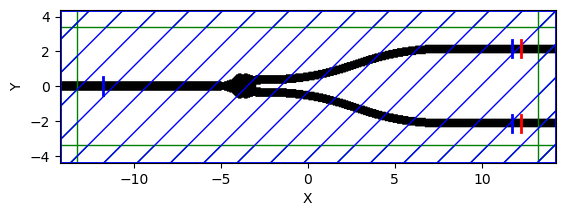

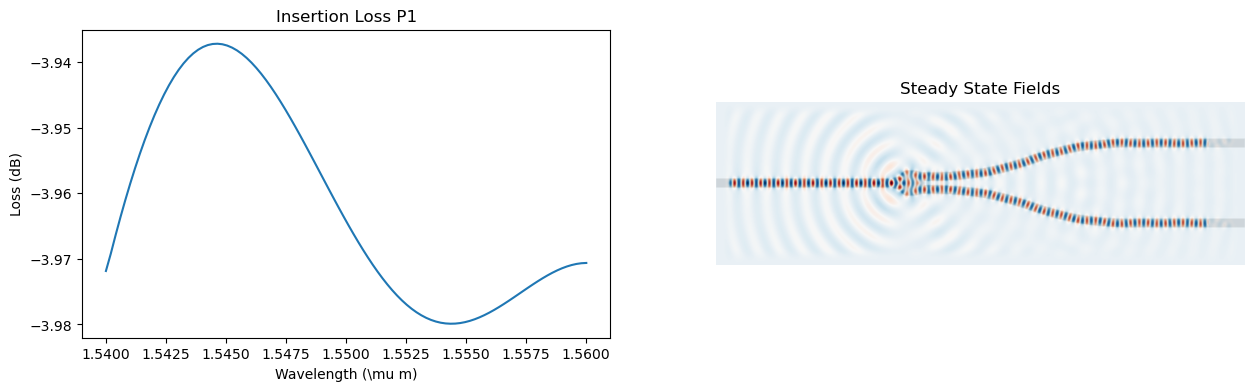

In [8]:
from gdsfactory.technology import LayerLevel, LayerStack

mp.verbosity(0)

# Set up frequency points for simulation
npoints = 100
lcen = 1.55
dlam = 0.02
wl = np.linspace(lcen - dlam / 2, lcen + dlam / 2, npoints)
fcen = 1 / lcen
fwidth = 3 * dlam / lcen**2
fpoints = 1 / wl  # Center frequency
mode_parity = mp.EVEN_Y + mp.ODD_Z
dpml = 1
dpad = 1
resolution = 20

# Define materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

cell_size = mp.Vector3(ybranch.xsize + 2 * dpml, ybranch.ysize + 2 * dpml + 2 * dpad, 0)

ybranch = gf.components.extend_ports(ybranch, port_names=["o1", "o2", "o3"], length=1)
ybranch = ybranch.copy()
ybranch.flatten()
ybranch.center = (0, 0)

geometry = gm.get_meep_geometry.get_meep_geometry_from_component(ybranch)

geometry = [
    mp.Prism(geom.vertices, geom.height, geom.axis, geom.center, material=Si)
    for geom in geometry
]

src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src=src,
        eig_band=1,
        eig_parity=mode_parity,
        eig_kpoint = mp.Vector3(-1,0,0),
        direction = mp.NO_DIRECTION,
        size=mp.Vector3(0, 1),
        center=mp.Vector3(ybranch.ports["o2"].x - dpml - 1, ybranch["o2"].y),
        amplitude=1
    ),
    mp.EigenModeSource(
        src=src,
        eig_band=1,
        eig_parity=mode_parity,
        eig_kpoint = mp.Vector3(-1,0,0),
        direction = mp.NO_DIRECTION,
        size=mp.Vector3(0, 1),
        center=mp.Vector3(ybranch.ports["o3"].x - dpml - 1, ybranch["o3"].y),
        amplitude=1
    ),
]
sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=[mp.PML(dpml)],  # 
    sources=source,  # The sources
    geometry=geometry,  # The geometry
    default_material=SiO2,
)
m1 = mp.Volume(
    center=mp.Vector3(ybranch.ports["o1"].x + dpml + 1 + 0.5, ybranch["o1"].y),
    size=mp.Vector3(0, 1),
)
m2 = mp.Volume(
    center=mp.Vector3(ybranch.ports["o2"].x - dpml - 1 - 0.5, ybranch["o2"].y),
    size=mp.Vector3(0, 1),
)
m3 = mp.Volume(
    center=mp.Vector3(ybranch.ports["o3"].x - dpml - 1 - 0.5, ybranch["o3"].y),
    size=mp.Vector3(0, 1),
)

mode_monitor_1 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m1))
mode_monitor_2 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m2))
mode_monitor_3 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m3))
whole_dft = sim.add_dft_fields([mp.Ez], fcen, 0, 1, center=mp.Vector3(), size=cell_size)

sim.plot2D(labels=False)

sim.run(until_after_sources=mp.stop_when_dft_decayed(tol=1e-4))

# Finds the S parameters
norm_mode_coeff = sim.get_eigenmode_coefficients(
    mode_monitor_2, [1], eig_parity=mode_parity
).alpha[0, :, 1] + sim.get_eigenmode_coefficients(
    mode_monitor_3, [1], eig_parity=mode_parity
).alpha[0, :, 1] # Adding both the ports input values

port1_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_1, [1], eig_parity=mode_parity).alpha[
        0, :, 1
    ]
    / norm_mode_coeff
)

port2_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_2, [1], eig_parity=mode_parity).alpha[
        0, :, 0
    ]
    / norm_mode_coeff
)
port3_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_3, [1], eig_parity=mode_parity).alpha[
        0, :, 0
    ]
    / norm_mode_coeff
)

# Calculates the transmittance based off of the S parameters
port1_trans = abs(port1_coeff) ** 2
port2_trans = abs(port2_coeff) ** 2
port3_trans = abs(port3_coeff) ** 2
insertion_loss_dB = 10*np.log10(port1_trans)

fig = plt.figure(figsize=(15, 4))

ax_loss = fig.add_subplot(1,2,1)
ax_loss.set_title("Insertion Loss P1")
ax_loss.plot(wl,insertion_loss_dB)
ax_loss.set_xlabel(r"Wavelength (\mu m)")
ax_loss.set_ylabel("Loss (dB)")

# ax_trans1 = fig.add_subplot(1, 3, 1)
# ax_trans1.set_title("Transmission per Port")
# ax_trans1.plot(wl, port1_trans, label=r"s1(23)^2") # Not the proper way to represent 
# ax_trans1.plot(wl, port2_trans, label=r"s22^2")
# ax_trans1.plot(wl, port3_trans, label=r"s33^2")
# ax_trans1.set_xlabel(r"Wavelength (\mu m)")
# ax_trans1.set_ylabel(r"Transmission")
# ax_trans1.legend()

# ax_phase1 = fig.add_subplot(1, 3, 2)
# ax_phase1.set_title("Phase per Port")
# ax_phase1.plot(
#     wl, np.unwrap(np.angle(port1_coeff) * 180 / np.pi), label=r"phase of s1(23)"
# )
# ax_phase1.plot(
#     wl, np.unwrap(np.angle(port2_coeff) * 180 / np.pi), label=r"phase of s22"
# )
# ax_phase1.plot(
#     wl, np.unwrap(np.angle(port3_coeff) * 180 / np.pi), label=r"phase of s33"
# )
# ax_phase1.set_xlabel(r"Wavelength (\mu m)")
# ax_phase1.set_ylabel("Angle (deg)")
# ax_phase1.legend()

# sim.reset_meep()

# sim.run(until_after_sources=mp.stop_when_dft_decayed(tol=1e-4))

eps_data = sim.get_epsilon()  #
ez_data = sim.get_dft_array(
    whole_dft, mp.Ez, 0
)  # Values for the component of the E-field in the z direction (in/out of screen)

# Creates the plot
ax_field = fig.add_subplot(1, 2, 2)
ax_field.set_title("Steady State Fields")
ax_field.imshow(np.transpose(eps_data), interpolation="spline36", cmap="binary")
ax_field.imshow(
    np.flipud(np.transpose(np.real(ez_data))),
    interpolation="spline36",
    cmap="RdBu",
    alpha=0.9,
)
ax_field.axis("off")
plt.show()

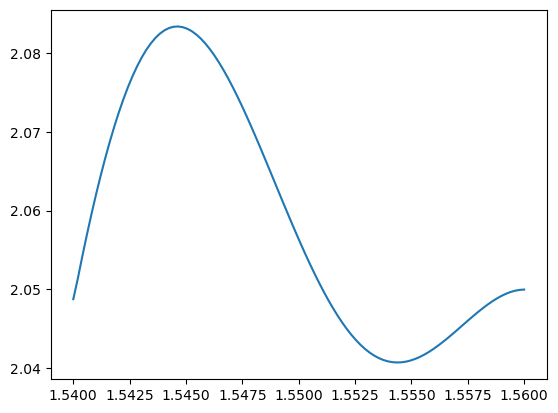

In [18]:
norm_mode_coeff = sim.get_eigenmode_coefficients(
    mode_monitor_3, [1], eig_parity=mode_parity
).alpha[0, :, 1] 
port1_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_1, [1], eig_parity=mode_parity).alpha[
        0, :, 1
    ]
    / norm_mode_coeff
)
port1_trans = abs(port1_coeff) ** 2
insertion_loss_dB = 10*np.log10(port1_trans)
plt.plot(wl, insertion_loss_dB)

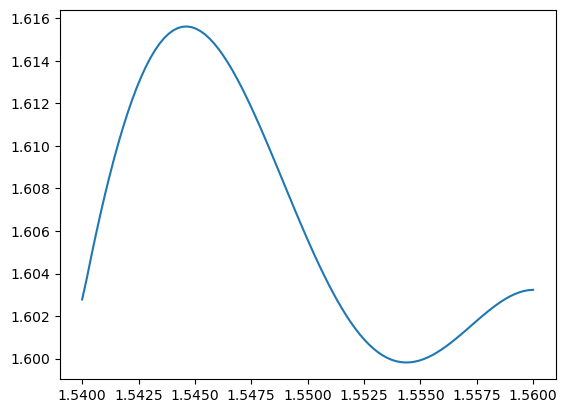

In [19]:
plt.plot(wl, port1_trans)